# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

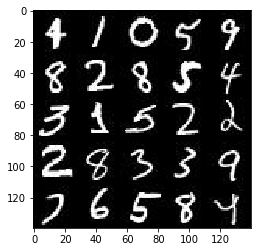

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

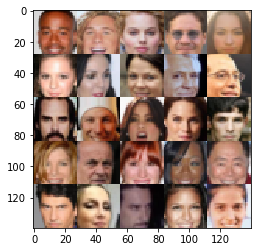

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, shape=())
    return inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


#### LeakyReLU

In [6]:
def l_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

#### Conv layers

In [7]:
def conv_layer(x, filter_, kernel_size=5, strides=2, training=True, rate=0.5):
    initializer = tf.contrib.layers.xavier_initializer()
    layer = tf.layers.conv2d(x, filter_, kernel_size, strides=strides, padding='same', 
                             activation=None, kernel_initializer=initializer)
    layer = tf.layers.batch_normalization(layer, training=training)
    layer = l_relu(layer)
    layer = tf.layers.dropout(layer, rate)
    return layer

def conv_transpose(x, filter_, kernel_size=5, strides=2, training=True, rate=0.5):
    initializer = tf.contrib.layers.xavier_initializer()
    layer = tf.layers.conv2d_transpose(x, filter_, kernel_size, strides=strides, padding='same', 
                                       activation=None, kernel_initializer=initializer)
    layer = tf.layers.batch_normalization(layer, training=training)
    layer = l_relu(layer)
    layer = tf.layers.dropout(layer, rate, training=training)
    return layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
         # Input layer is 28x28xchannels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = l_relu(x1)
        # 14x14x64
        
        x2 = conv_layer(x1, 128)
        # 7x7x128
        
        
        x3 = conv_layer(x2, 256)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 7*7*512, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = l_relu(x1)
        # 4x4x512 now
        
        x2 = conv_transpose(x1, 256, training=is_train)
        # 8x8x256 now
        
        x3 = conv_transpose(x2, 128, strides=1, training=is_train)
        # 14x14x128 
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', activation=None, 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        
        out = tf.divide(tf.tanh(logits), 2)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    gen = generator(input_z, out_channel_dim)
    model_real, logits_real = discriminator(input_real)
    model_gen, logits_gen = discriminator(gen, reuse=True)
    
    dloss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(model_real) * (1-smooth)))
    dloss_gen = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_gen, labels=tf.zeros_like(model_gen)))
    gloss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_gen, labels=tf.ones_like(model_gen)))
    dloss = dloss_real + dloss_gen
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get trainable variables
    trainable = tf.trainable_variables()
    d_trainable = [var for var in trainable if var.name.startswith('discriminator')]
    g_trainable = [var for var in trainable if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_trainable)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_trainable)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs, zinputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dloss, gloss = model_loss(inputs, zinputs, data_shape[3])
    dtrain, gtrain = model_opt(dloss, gloss, lr, beta1)
    
    with tf.Session() as sess:
        try:
            sess.run(tf.global_variables_initializer())
            for epoch_i in range(epoch_count):
                steps = 0
                for batch_images in get_batches(batch_size):

                    steps += 1
                    batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                    _ = sess.run(dtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate/2})


                    # Train generator twice
                    _ = sess.run(gtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate})
                    _ = sess.run(gtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate})
                    if steps == 1:
                        show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)

                    if steps % 10 == 0:
                        dloss_value = dloss.eval({inputs:batch_images, zinputs: batch_z})
                        gloss_value = gloss.eval({zinputs: batch_z})
                        print("Step {}...".format(steps),
                              "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(dloss_value),
                              "Generator Loss: {:.4f}".format(gloss_value))

                    if steps % 100 == 0:
                        can_show = True
                        show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)

            # Show at the end
            show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)
        except KeyboardInterrupt:
            print("Training interrupted.")
        show_generator_output(sess, 9, zinputs, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

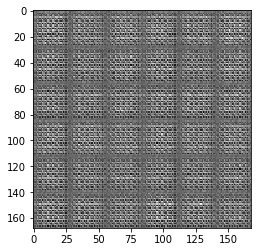

Step 10... Epoch 1/2... Discriminator Loss: 2.2736... Generator Loss: 0.9112
Step 20... Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.7443
Step 30... Epoch 1/2... Discriminator Loss: 2.0504... Generator Loss: 0.7146
Step 40... Epoch 1/2... Discriminator Loss: 1.9191... Generator Loss: 0.6675
Step 50... Epoch 1/2... Discriminator Loss: 1.8444... Generator Loss: 0.5018
Step 60... Epoch 1/2... Discriminator Loss: 1.8371... Generator Loss: 0.3699
Step 70... Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.7360
Step 80... Epoch 1/2... Discriminator Loss: 1.8775... Generator Loss: 0.3702
Step 90... Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.5752
Step 100... Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.8563


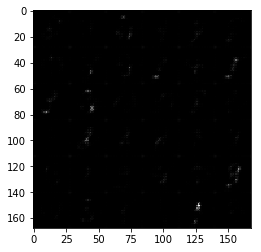

Step 110... Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 0.4866
Step 120... Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.6521
Step 130... Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 1.0381
Step 140... Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.9825
Step 150... Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.9669
Step 160... Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.5541
Step 170... Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.5352
Step 180... Epoch 1/2... Discriminator Loss: 1.7038... Generator Loss: 0.3872
Step 190... Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.9569
Step 200... Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 1.2637


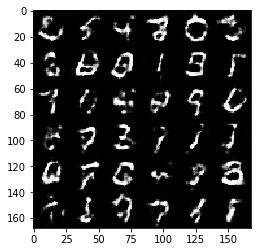

Step 210... Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.8654
Step 220... Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.7085
Step 230... Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.5443
Step 240... Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.6927
Step 250... Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.9912
Step 260... Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.6952
Step 270... Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.7127
Step 280... Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 1.0112
Step 290... Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.9134
Step 300... Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.9755


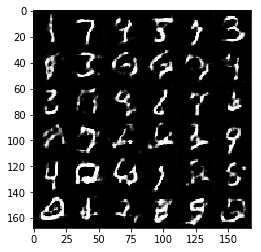

Step 310... Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.7774
Step 320... Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.9072
Step 330... Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.4947
Step 340... Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.8902
Step 350... Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.6343
Step 360... Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.6400
Step 370... Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 1.0605
Step 380... Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.6922
Step 390... Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.7532
Step 400... Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.6450


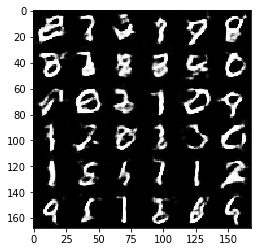

Step 410... Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 0.6315
Step 420... Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.8888
Step 430... Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.6215
Step 440... Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.7250
Step 450... Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.7586
Step 460... Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.9044
Step 470... Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.7316
Step 480... Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7378
Step 490... Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.6455
Step 500... Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.6411


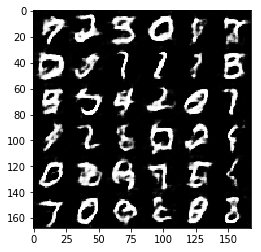

Step 510... Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 1.1705
Step 520... Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.8310
Step 530... Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 1.0413
Step 540... Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.6840
Step 550... Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8376
Step 560... Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.5490
Step 570... Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.6251
Step 580... Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.6726
Step 590... Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.8989
Step 600... Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8992


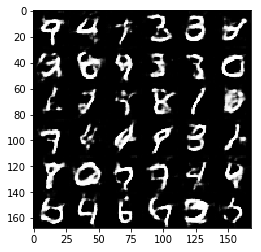

Step 610... Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.8395
Step 620... Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.5089
Step 630... Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7205
Step 640... Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5225
Step 650... Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8993
Step 660... Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.5348
Step 670... Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.8886
Step 680... Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.8290
Step 690... Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.8932
Step 700... Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.4345


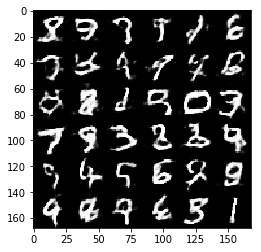

Step 710... Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.6554
Step 720... Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 1.0689
Step 730... Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.6230
Step 740... Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.8981
Step 750... Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.9929
Step 760... Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 1.1019
Step 770... Epoch 1/2... Discriminator Loss: 1.5321... Generator Loss: 1.6310
Step 780... Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.7886
Step 790... Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.7149
Step 800... Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.1263


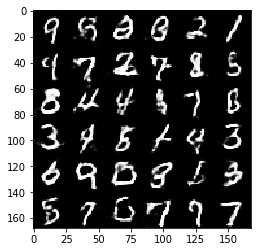

Step 810... Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.8302
Step 820... Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 1.3932
Step 830... Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.9537
Step 840... Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.8870
Step 850... Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.4577
Step 860... Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.6666
Step 870... Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.0911
Step 880... Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.0683
Step 890... Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.6255
Step 900... Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 1.2667


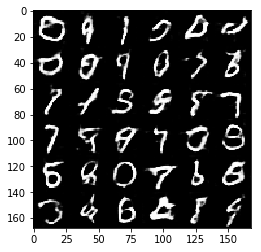

Step 910... Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.7918
Step 920... Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.9998
Step 930... Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 1.2224


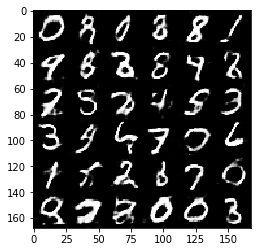

Step 10... Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.7293
Step 20... Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.7759
Step 30... Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.7734
Step 40... Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 1.0682
Step 50... Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.1540
Step 60... Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.7643
Step 70... Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.5534
Step 80... Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.7849
Step 90... Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.7411
Step 100... Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.8196


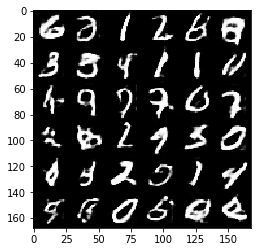

Step 110... Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.5091
Step 120... Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.5480
Step 130... Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.0403
Step 140... Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.7326
Step 150... Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.7555
Step 160... Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 1.3746
Step 170... Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.9529
Step 180... Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 1.0559
Step 190... Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 0.9206
Step 200... Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.6088


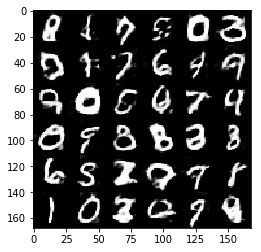

Step 210... Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.6509
Step 220... Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.8171
Step 230... Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.8898
Step 240... Epoch 2/2... Discriminator Loss: 1.8097... Generator Loss: 0.3355
Step 250... Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.9260
Step 260... Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.7587
Step 270... Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.1473
Step 280... Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.2819
Step 290... Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.3744
Step 300... Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 1.1134


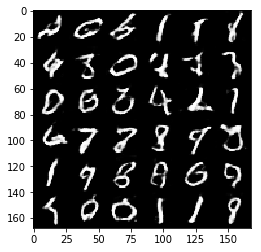

Step 310... Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.8900
Step 320... Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.9105
Step 330... Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 1.0556
Step 340... Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.1090
Step 350... Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.8277
Step 360... Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 0.9403
Step 370... Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.2823
Step 380... Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.1363
Step 390... Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 0.8747
Step 400... Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.8272


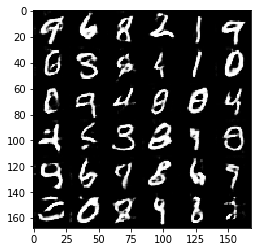

Step 410... Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 1.1796
Step 420... Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 1.9477
Step 430... Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.6969
Step 440... Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.2022
Step 450... Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.0100
Step 460... Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.5220
Step 470... Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.2088
Step 480... Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.7439
Step 490... Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.2165
Step 500... Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.8658


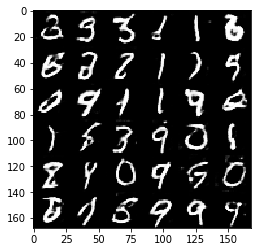

Step 510... Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 1.8145
Step 520... Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.0076
Step 530... Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 1.4104
Step 540... Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.3574
Step 550... Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.0577
Step 560... Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.8337
Step 570... Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.4619
Step 580... Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.2706
Step 590... Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.5875
Step 600... Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.1921


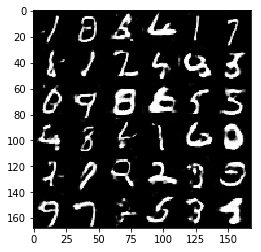

Step 610... Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.6833
Step 620... Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.5906
Step 630... Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.2293
Step 640... Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.1834
Step 650... Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.6667
Step 660... Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.2299
Step 670... Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 1.7705
Step 680... Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.1568
Step 690... Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.0131
Step 700... Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.2051


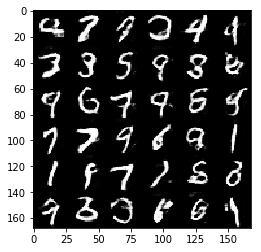

Step 710... Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.3119
Step 720... Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 0.9756
Step 730... Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 2.1158
Step 740... Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 0.9818
Step 750... Epoch 2/2... Discriminator Loss: 0.6447... Generator Loss: 1.8276
Step 760... Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.7306
Step 770... Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 2.2451
Step 780... Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 2.5311
Step 790... Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 2.0702
Step 800... Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.9127


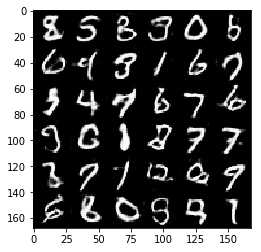

Step 810... Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.6459
Step 820... Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.6276
Step 830... Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.9132
Step 840... Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 2.2604
Step 850... Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.8649
Step 860... Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 2.2463
Step 870... Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.1995
Step 880... Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 2.0225
Step 890... Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.1697
Step 900... Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 1.9442


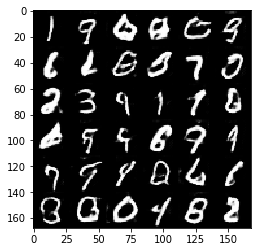

Step 910... Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.8948
Step 920... Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.5532
Step 930... Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.9819


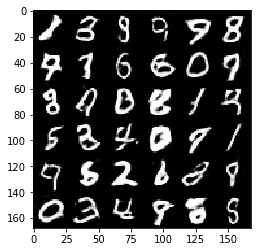

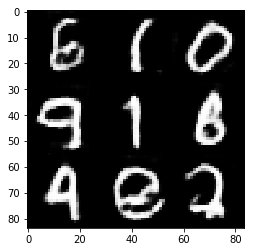

In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

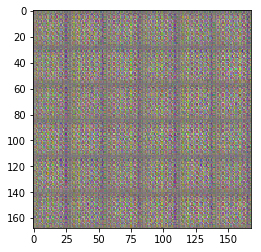

Step 10... Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 0.6709
Step 20... Epoch 1/1... Discriminator Loss: 2.3507... Generator Loss: 0.3267
Step 30... Epoch 1/1... Discriminator Loss: 2.0421... Generator Loss: 0.4490
Step 40... Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.1817
Step 50... Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.9024
Step 60... Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.9156
Step 70... Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.3750
Step 80... Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7141
Step 90... Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7586
Step 100... Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6389


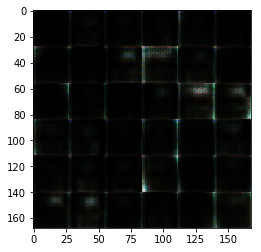

Step 110... Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.9884
Step 120... Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.9333
Step 130... Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.7167
Step 140... Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.6031
Step 150... Epoch 1/1... Discriminator Loss: 1.7155... Generator Loss: 0.5517
Step 160... Epoch 1/1... Discriminator Loss: 1.7571... Generator Loss: 0.5422
Step 170... Epoch 1/1... Discriminator Loss: 1.9360... Generator Loss: 0.4014
Step 180... Epoch 1/1... Discriminator Loss: 1.8370... Generator Loss: 0.7411
Step 190... Epoch 1/1... Discriminator Loss: 1.7380... Generator Loss: 0.7053
Step 200... Epoch 1/1... Discriminator Loss: 1.9348... Generator Loss: 0.6096


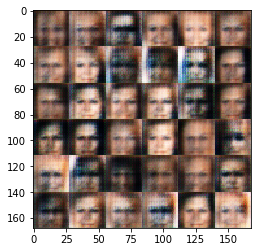

Step 210... Epoch 1/1... Discriminator Loss: 1.8092... Generator Loss: 0.5590
Step 220... Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6107
Step 230... Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.4855
Step 240... Epoch 1/1... Discriminator Loss: 2.0413... Generator Loss: 0.4669
Step 250... Epoch 1/1... Discriminator Loss: 2.1656... Generator Loss: 0.4892
Step 260... Epoch 1/1... Discriminator Loss: 2.2420... Generator Loss: 0.4547
Step 270... Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.6598
Step 280... Epoch 1/1... Discriminator Loss: 1.8001... Generator Loss: 0.6101
Step 290... Epoch 1/1... Discriminator Loss: 1.8875... Generator Loss: 0.5182
Step 300... Epoch 1/1... Discriminator Loss: 1.8458... Generator Loss: 0.5455


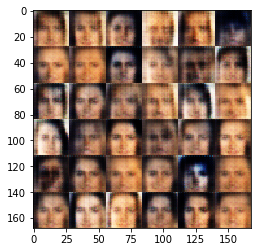

Step 310... Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7181
Step 320... Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6611
Step 330... Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.6106
Step 340... Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.6393
Step 350... Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.6470
Step 360... Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.7249
Step 370... Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6541
Step 380... Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7198
Step 390... Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7799
Step 400... Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.5707


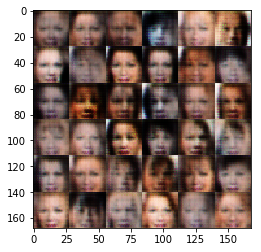

Step 410... Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.5984
Step 420... Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.6548
Step 430... Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.7527
Step 440... Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7590
Step 450... Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6397
Step 460... Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7243
Step 470... Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6820
Step 480... Epoch 1/1... Discriminator Loss: 1.8081... Generator Loss: 0.5355
Step 490... Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.7026
Step 500... Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.7384


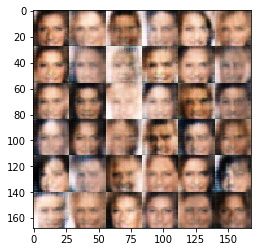

Step 510... Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.6689
Step 520... Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.6821
Step 530... Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7904
Step 540... Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.7115
Step 550... Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7554
Step 560... Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.6798
Step 570... Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.7470
Step 580... Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.6386
Step 590... Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.6630
Step 600... Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.7063


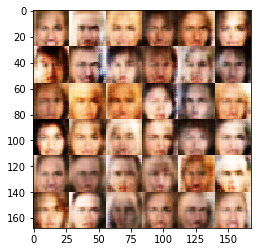

Step 610... Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7821
Step 620... Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7371
Step 630... Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.6115
Step 640... Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7750
Step 650... Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.7825
Step 660... Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.7586
Step 670... Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7107
Step 680... Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.6512
Step 690... Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6853
Step 700... Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.6729


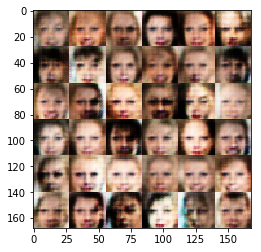

Step 710... Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7573
Step 720... Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7216
Step 730... Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7310
Step 740... Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.7510
Step 750... Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.6344
Step 760... Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.6972
Step 770... Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.6855
Step 780... Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8323
Step 790... Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.7825
Step 800... Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6394


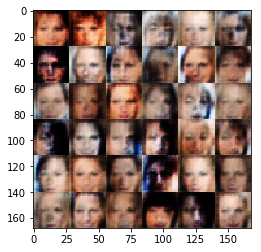

Step 810... Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6760
Step 820... Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7031
Step 830... Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.7184
Step 840... Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7341
Step 850... Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7301
Step 860... Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.6232
Step 870... Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.7645
Step 880... Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6899
Step 890... Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7212
Step 900... Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6858


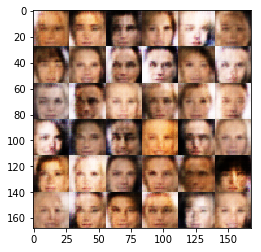

Step 910... Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.8386
Step 920... Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7219
Step 930... Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6549
Step 940... Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7184
Step 950... Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7448
Step 960... Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8127
Step 970... Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.7014
Step 980... Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7554
Step 990... Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6735
Step 1000... Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.7105


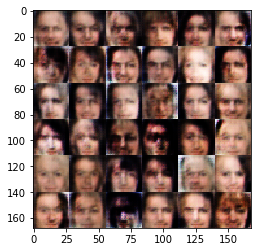

Step 1010... Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7945
Step 1020... Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.7196
Step 1030... Epoch 1/1... Discriminator Loss: 1.6154... Generator Loss: 0.6047
Step 1040... Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7426
Step 1050... Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.6038
Step 1060... Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7968
Step 1070... Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7595
Step 1080... Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7696
Step 1090... Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.6779
Step 1100... Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.7457


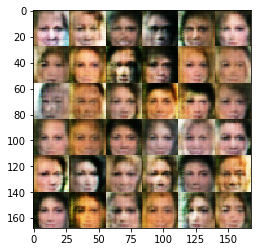

Step 1110... Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6937
Step 1120... Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.7617
Step 1130... Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7299
Step 1140... Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6819
Step 1150... Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6750
Step 1160... Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7234
Step 1170... Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6845
Step 1180... Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7790
Step 1190... Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7158
Step 1200... Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.7238


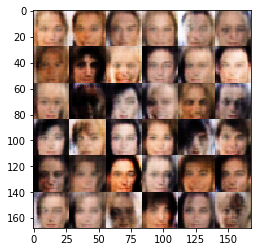

Step 1210... Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7688
Step 1220... Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7238
Step 1230... Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7073
Step 1240... Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6874
Step 1250... Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7869
Step 1260... Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.6217
Step 1270... Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7495
Step 1280... Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7610
Step 1290... Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7327
Step 1300... Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7877


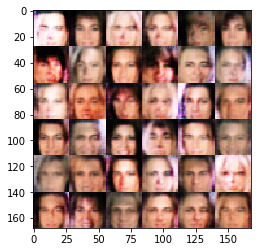

Step 1310... Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7191
Step 1320... Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7572
Step 1330... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7826
Step 1340... Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7343
Step 1350... Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.6911
Step 1360... Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7988
Step 1370... Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7204
Step 1380... Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7460
Step 1390... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7603
Step 1400... Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7245


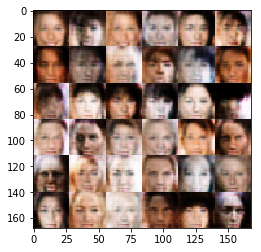

Step 1410... Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7295
Step 1420... Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6559
Step 1430... Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.7479
Step 1440... Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.7240
Step 1450... Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7400
Step 1460... Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.6496
Step 1470... Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8002
Step 1480... Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6659
Step 1490... Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.6593
Step 1500... Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.7426


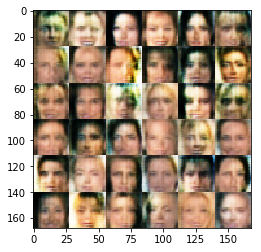

Step 1510... Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6781
Step 1520... Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.7224
Step 1530... Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7958
Step 1540... Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7832
Step 1550... Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7428
Step 1560... Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.7576
Step 1570... Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7519
Step 1580... Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7034
Step 1590... Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6807
Step 1600... Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7210


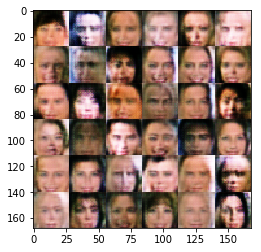

Step 1610... Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7593
Step 1620... Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7766
Step 1630... Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7611
Step 1640... Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7117
Step 1650... Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7844
Step 1660... Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7411
Step 1670... Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7668
Step 1680... Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7777
Step 1690... Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7533
Step 1700... Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6883


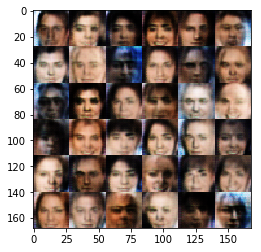

Step 1710... Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.8016
Step 1720... Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7029
Step 1730... Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7529
Step 1740... Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7829
Step 1750... Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7624
Step 1760... Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7275
Step 1770... Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7662
Step 1780... Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7446
Step 1790... Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.7563
Step 1800... Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7628


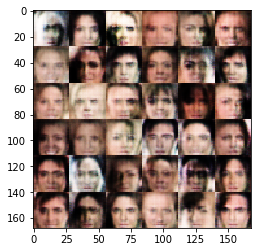

Step 1810... Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7482
Step 1820... Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7486
Step 1830... Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7797
Step 1840... Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7531
Step 1850... Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7450
Step 1860... Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7341
Step 1870... Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7772
Step 1880... Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.7143
Step 1890... Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7231
Step 1900... Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7615


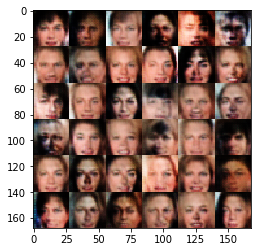

Step 1910... Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7211
Step 1920... Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6243
Step 1930... Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7891
Step 1940... Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7531
Step 1950... Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7462
Step 1960... Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7873
Step 1970... Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7641
Step 1980... Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7703
Step 1990... Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7776
Step 2000... Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7630


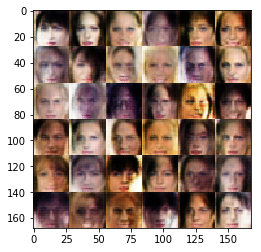

Step 2010... Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7619
Step 2020... Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7037
Step 2030... Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7526
Step 2040... Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7507
Step 2050... Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7016
Step 2060... Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6832
Step 2070... Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8324
Step 2080... Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7652
Step 2090... Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7757
Step 2100... Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7196


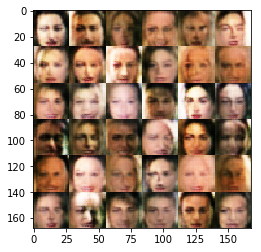

Step 2110... Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8921
Step 2120... Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6456
Step 2130... Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7586
Step 2140... Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7538
Step 2150... Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7485
Step 2160... Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7745
Step 2170... Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7667
Step 2180... Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7454
Step 2190... Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7301
Step 2200... Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7751


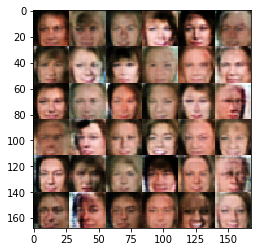

Step 2210... Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7491
Step 2220... Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7336
Step 2230... Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7902
Step 2240... Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7394
Step 2250... Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8565
Step 2260... Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7071
Step 2270... Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.7486
Step 2280... Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7831
Step 2290... Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8093
Step 2300... Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7108


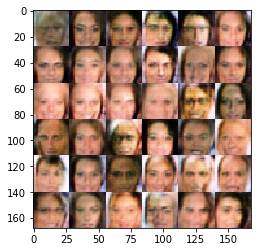

Step 2310... Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7267
Step 2320... Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7410
Step 2330... Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7252
Step 2340... Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6301
Step 2350... Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6996
Step 2360... Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8051
Step 2370... Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7066
Step 2380... Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6967
Step 2390... Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.9075
Step 2400... Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6283


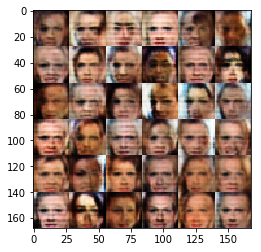

Step 2410... Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7233
Step 2420... Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.7749
Step 2430... Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7664
Step 2440... Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7520
Step 2450... Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8154
Step 2460... Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7786
Step 2470... Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7360
Step 2480... Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7686
Step 2490... Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7605
Step 2500... Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7797


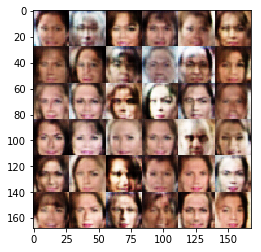

Step 2510... Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7288
Step 2520... Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7738
Step 2530... Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7636
Step 2540... Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7804
Step 2550... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7840
Step 2560... Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7191
Step 2570... Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.8085
Step 2580... Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7499
Step 2590... Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.8132
Step 2600... Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7523


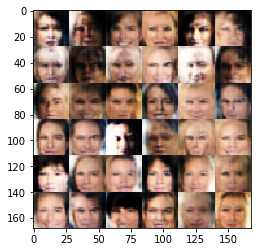

Step 2610... Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7427
Step 2620... Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7017
Step 2630... Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7938
Step 2640... Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7953
Step 2650... Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7822
Step 2660... Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7498
Step 2670... Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7400
Step 2680... Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7555
Step 2690... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7053
Step 2700... Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7158


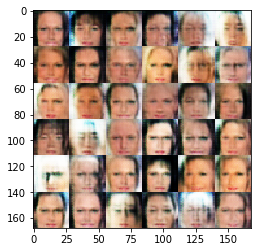

Step 2710... Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7315
Step 2720... Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7908
Step 2730... Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6850
Step 2740... Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7342
Step 2750... Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7425
Step 2760... Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7470
Step 2770... Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7211
Step 2780... Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7882
Step 2790... Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8013
Step 2800... Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7008


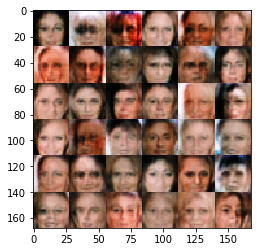

Step 2810... Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7196
Step 2820... Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7729
Step 2830... Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7261
Step 2840... Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7274
Step 2850... Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7054
Step 2860... Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7049
Step 2870... Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8127
Step 2880... Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7231
Step 2890... Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7645
Step 2900... Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7546


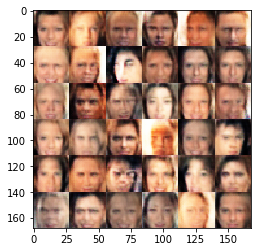

Step 2910... Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.8096
Step 2920... Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7329
Step 2930... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8014
Step 2940... Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7789
Step 2950... Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7855
Step 2960... Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6922
Step 2970... Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6849
Step 2980... Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7700
Step 2990... Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7427
Step 3000... Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7420


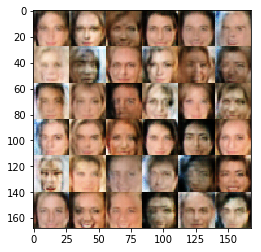

Step 3010... Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6447
Step 3020... Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7123
Step 3030... Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8088
Step 3040... Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8344
Step 3050... Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7721
Step 3060... Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7086
Step 3070... Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6971
Step 3080... Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7609
Step 3090... Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7299
Step 3100... Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7188


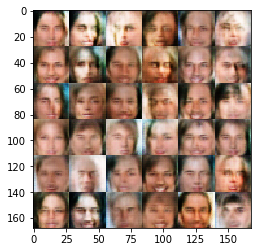

Step 3110... Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6918
Step 3120... Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7717
Step 3130... Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8341
Step 3140... Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7450
Step 3150... Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7795
Step 3160... Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7933
Step 3170... Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7056
Step 3180... Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7112
Step 3190... Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.8243
Step 3200... Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7092


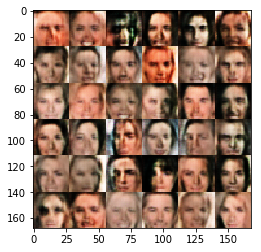

Step 3210... Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7472
Step 3220... Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7533
Step 3230... Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8303
Step 3240... Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7422
Step 3250... Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7775
Step 3260... Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7377
Step 3270... Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7282
Step 3280... Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8351
Step 3290... Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7317
Step 3300... Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7581


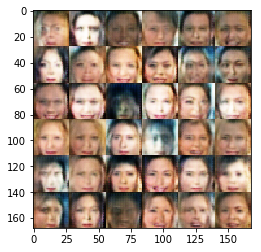

Step 3310... Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.8251
Step 3320... Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6856
Step 3330... Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6979
Step 3340... Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7520
Step 3350... Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7430
Step 3360... Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7717
Step 3370... Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7375
Step 3380... Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8223
Step 3390... Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7880
Step 3400... Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7315


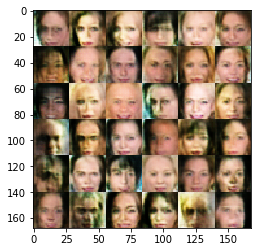

Step 3410... Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7045
Step 3420... Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6953
Step 3430... Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7698
Step 3440... Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7045
Step 3450... Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7385
Step 3460... Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7716
Step 3470... Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7030
Step 3480... Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7503
Step 3490... Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7602
Step 3500... Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7791


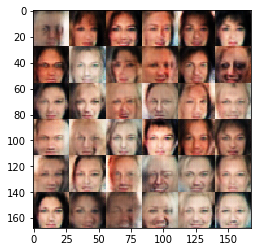

Step 3510... Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7672
Step 3520... Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7329
Step 3530... Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7142
Step 3540... Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7265
Step 3550... Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7204
Step 3560... Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7375
Step 3570... Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7106
Step 3580... Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7853
Step 3590... Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7473
Step 3600... Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8074


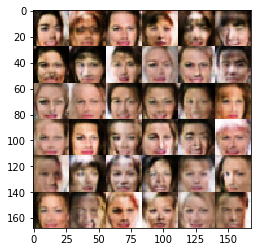

Step 3610... Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7318
Step 3620... Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7405
Step 3630... Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7289
Step 3640... Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7257
Step 3650... Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7028
Step 3660... Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7712
Step 3670... Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7527
Step 3680... Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7847
Step 3690... Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7587
Step 3700... Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7333


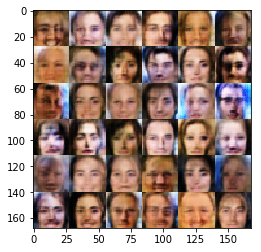

Step 3710... Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7617
Step 3720... Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7662
Step 3730... Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6607
Step 3740... Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8340
Step 3750... Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6858
Step 3760... Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7568
Step 3770... Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7254
Step 3780... Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7257
Step 3790... Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7315
Step 3800... Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7554


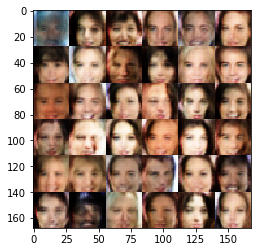

Step 3810... Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7359
Step 3820... Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7609
Step 3830... Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8364
Step 3840... Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7805
Step 3850... Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8040
Step 3860... Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7668
Step 3870... Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7278
Step 3880... Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6975
Step 3890... Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7222
Step 3900... Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.6914


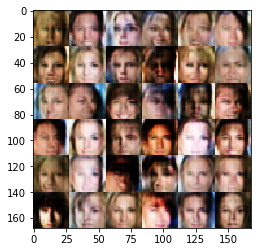

Step 3910... Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7987
Step 3920... Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7987
Step 3930... Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7619
Step 3940... Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7763
Step 3950... Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8434
Step 3960... Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7858
Step 3970... Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7434
Step 3980... Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7295
Step 3990... Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7500
Step 4000... Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8094


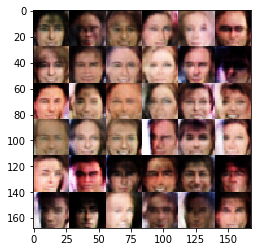

Step 4010... Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7845
Step 4020... Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7426
Step 4030... Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7562
Step 4040... Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8314
Step 4050... Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7514
Step 4060... Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7402
Step 4070... Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8302
Step 4080... Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.7153
Step 4090... Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7574
Step 4100... Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.7891


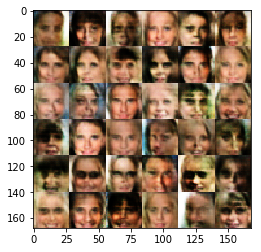

Step 4110... Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6820
Step 4120... Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7281
Step 4130... Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7968
Step 4140... Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7443
Step 4150... Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6482
Step 4160... Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7496
Step 4170... Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7352
Step 4180... Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8181
Step 4190... Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6692
Step 4200... Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7655


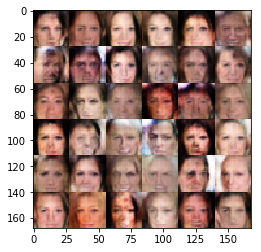

Step 4210... Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7078
Step 4220... Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7597
Step 4230... Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7085
Step 4240... Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7448
Step 4250... Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.7410
Step 4260... Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6504
Step 4270... Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7467
Step 4280... Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7758
Step 4290... Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7681
Step 4300... Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7561


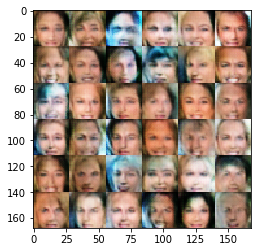

Step 4310... Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8327
Step 4320... Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7695
Step 4330... Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7505
Step 4340... Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7920
Step 4350... Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.7267
Step 4360... Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7699
Step 4370... Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6784
Step 4380... Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7459
Step 4390... Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6882
Step 4400... Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7962


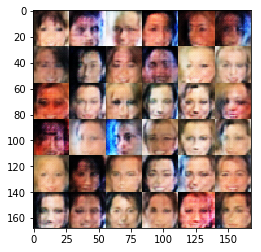

Step 4410... Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7591
Step 4420... Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.8992
Step 4430... Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8686
Step 4440... Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7210
Step 4450... Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6988
Step 4460... Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7553
Step 4470... Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7701
Step 4480... Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6804
Step 4490... Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7800
Step 4500... Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7543


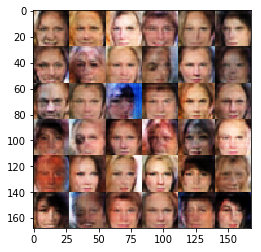

Step 4510... Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6328
Step 4520... Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7298
Step 4530... Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7246
Step 4540... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7664
Training interrupted.


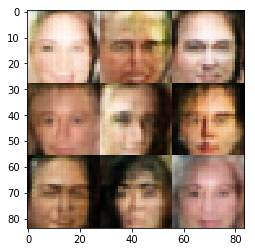

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.